# Capstone project: Exploring the neighborhoods of Toronto with location data 

### Lifu Deng

### 12/2020

### all analyses are included in this notebook


# Data acquisition and cleaning



In [5]:
# import libraries that will be used later
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt




# loading saved foursquare credentials in a local file
with open('foursquareCredentials.json') as js:
    fscredential=json.load(js)

# loading postal code table
dflink='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df_raw=pd.read_html(dflink)
df_raw=df_raw[0]
df_raw=df_raw[df_raw['Borough']!='Not assigned']

postcode=df_raw['Postal Code'].unique()
df_new=pd.DataFrame(columns=['Postal Code','Borough','Neighbourhood'])
for i in range(postcode.size):
    df_tmp=df_raw[df_raw['Postal Code']==postcode[i]]
    tmpstr=''
    for j in range(df_tmp.shape[0]):
        if j>0:
            tmpstr=tmpstr+', '+df_tmp.iloc[j,2]
        else:
            tmpstr=tmpstr+df_tmp.iloc[j,2]     
    df_new=df_new.append({'Postal Code':df_tmp.iloc[0,0],
                  'Borough':df_tmp.iloc[0,1],
                  'Neighbourhood':tmpstr},ignore_index=True)
for i in range(df_new.shape[0]):
    if df_new.iloc[i,1]=='Not assigned':
        df_new.iloc[i,1]=df_new.iloc[i,2]
        
# now insert geospatial data into the dataframe
# initialize two new columns
df_new['Latitude']=0
df_new['Longitude']=0
# this is a dataframe of coordinates
df_coord=pd.read_csv('http://cocl.us/Geospatial_data')
# adding coordinate information into the main dataframe
for i in df_new['Postal Code']:
    df_new.loc[df_new['Postal Code']==i,'Latitude']=df_coord[df_coord['Postal Code']==i].iloc[0,1]
    df_new.loc[df_new['Postal Code']==i,'Longitude']=df_coord[df_coord['Postal Code']==i].iloc[0,2]
    
df_new=df_new[df_new['Borough'].str.contains("Toronto")]
df_new.head()

The rows of the dataframe = 103
Data cleaning is done!


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [7]:
# save data
df_new.to_csv("postal_table_toronto.csv")

In [9]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests # library to handle requests

df_toronto=df_new
with open('foursquareCredentials.json') as js:
    fscredential=json.load(js)
CLIENT_ID = fscredential['Client_Id'] # your Foursquare ID
CLIENT_SECRET = fscredential['Client Secret'] # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 150 # A default Foursquare API limit value
radius = 500 # define radius



def getNearbyVenues(pcodes, names, latitudes, longitudes, radius=500):
    venues_list=[]
    for pcode, name, lat, lng in zip(pcodes, names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)      
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            pcode, name, lat, lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode','Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 
                  'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(nearby_venues)

toronto_venues = getNearbyVenues(pcodes=df_toronto['Postal Code'],
    names=df_toronto['Neighbourhood'],latitudes=df_toronto['Latitude'],longitudes=df_toronto['Longitude'])
toronto_venues.shape
toronto_venues.head()

,PostalCode,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,M5A,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,M5A,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [36]:

df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Total_venues,Venue_types,Venues_per_type
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,46,30,1.533333
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,33,26,1.269231
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,100,62,1.612903
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,81,52,1.557692
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,4,4,1.000000


In [32]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

toronto_venues=pd.read_csv('venue_table_toronto.csv')
toronto_venues=toronto_venues.drop(columns='Unnamed: 0')
df_toronto=pd.read_csv('postal_table_toronto.csv')
df_toronto=df_toronto.drop(columns='Unnamed: 0')

In [40]:
df_toronto['Total_venues']=0
for i in df_toronto['Postal Code']:
    df_toronto.loc[df_toronto['Postal Code']==i,'Total_venues']=np.sum(toronto_venues['PostalCode']==i)

df_toronto['Venue_types']=0
for i in df_toronto['Postal Code']:
    df_toronto.loc[df_toronto['Postal Code']==i,'Venue_types']=len(
        toronto_venues[toronto_venues['PostalCode']==i]['Venue Category'].unique().tolist())

# exploring measures of interests

[]

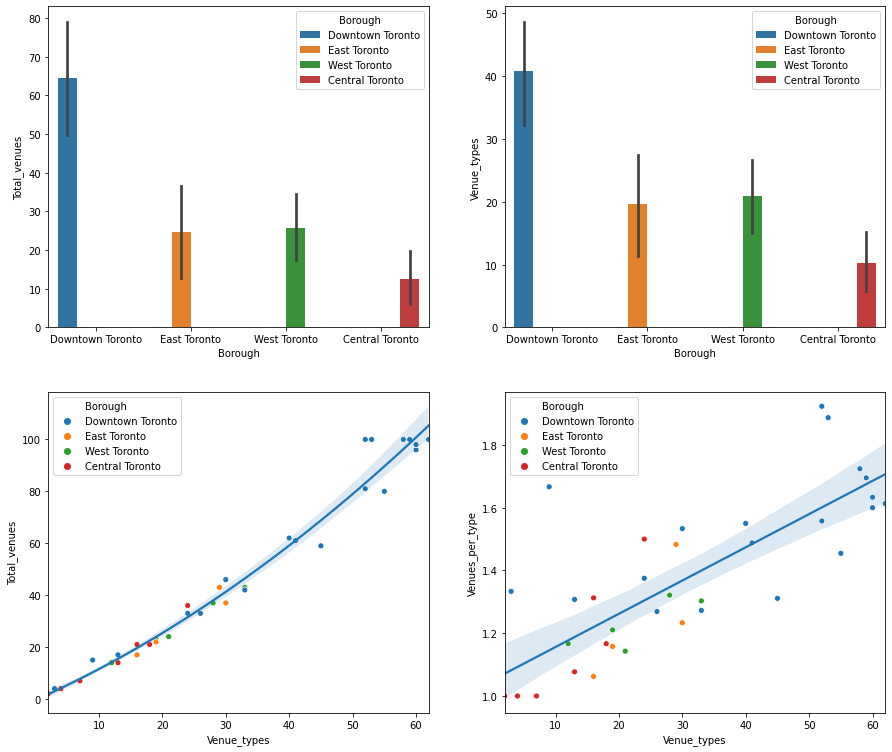

In [59]:
df_toronto['Venues_per_type']=df_toronto['Total_venues']/df_toronto['Venue_types']


g,Ax=plt.subplots(2,2)
sns.barplot(ax=Ax[0,0],data=df_toronto,x='Borough',y='Total_venues',hue='Borough')
sns.barplot(ax=Ax[0,1],data=df_toronto,x='Borough',y='Venue_types',hue='Borough')

sns.regplot(ax=Ax[1,0],data=df_toronto,x='Venue_types',y='Total_venues',order=2,scatter=False)
sns.scatterplot(ax=Ax[1,0],data=df_toronto,x='Venue_types',y='Total_venues',hue='Borough')

sns.regplot(ax=Ax[1,1],data=df_toronto,y='Venues_per_type',x='Venue_types',scatter=False)
sns.scatterplot(ax=Ax[1,1],data=df_toronto,y='Venues_per_type',x='Venue_types',hue='Borough')

g.set_size_inches(15,13)
ax[1].set_yticks([])

In [15]:
venue_list=toronto_venues.groupby('Venue Category').count()
venue_list=venue_list.drop(columns=['Neighbourhood','Neighbourhood Latitude','Neighbourhood Longitude',
                                   'Venue Latitude','Venue Longitude','PostalCode'])
venue_list.columns=['Total_Count']
venue_list.sort_values(by='Total_Count',ascending=False,inplace=True)
venue_list=venue_list.reset_index()

for i in df_toronto['Postal Code']:
    venue_list[i]=0
    for j in venue_list['Venue Category']:
        venue_list.loc[venue_list['Venue Category']==j,i]=len(
            toronto_venues[(toronto_venues['Venue Category']==j) & (toronto_venues['PostalCode']==i)]['Venue'].tolist())

venue_list.head(10)

,Venue Category,Total_Count,M5A,M7A,M5B,M5C,M4E,M5E,M5G,M6G,...,M4T,M5T,M4V,M5V,M4W,M5W,M4X,M5X,M4Y,M7Y
0,Coffee Shop,151,7,7,10,6,0,5,11,1,...,0,4,2,1,0,11,3,10,6,0
1,Café,85,3,1,4,4,0,1,3,3,...,0,5,0,0,0,3,3,7,2,0
2,Restaurant,53,1,1,1,2,0,2,1,1,...,1,0,1,0,0,3,2,4,3,1
3,Italian Restaurant,43,0,1,2,2,0,1,3,1,...,0,0,0,0,0,4,2,1,1,0
4,Park,36,3,1,1,2,0,1,1,2,...,1,2,0,0,2,2,1,0,1,1
5,Hotel,36,1,0,3,2,0,1,0,0,...,0,0,0,0,0,2,0,5,2,0
6,Japanese Restaurant,34,0,1,3,2,0,1,1,0,...,0,1,0,0,0,3,1,4,5,0
7,Bakery,31,3,0,1,1,0,3,0,0,...,0,1,0,0,0,3,2,1,0,0
8,Pizza Place,28,0,0,2,0,0,0,0,0,...,0,1,1,0,0,0,2,2,2,1
9,Bar,24,0,1,0,0,0,0,1,0,...,0,2,0,0,0,0,0,2,0,0


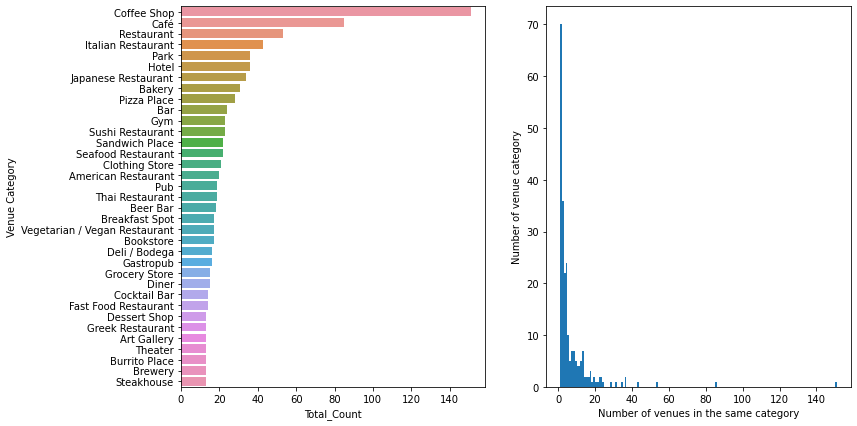

In [39]:
g,ax=plt.subplots(1,2)
venue_list['Total_Count'].plot.hist(bins=150,ax=ax[1])
ax[1].set_xlabel('Number of venues in the same category')
ax[1].set_ylabel('Number of venue category')
sns.barplot(data=venue_list[0:35],y='Venue Category',x='Total_Count',ax=ax[0])
g.set_size_inches(12,7)

In [99]:
sum(venue_list['Total_Count']>2)

128

# visualization of geographical data 

In [16]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests # library to handle requests
import branca
import branca.colormap as cmap

address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))


map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'], 
                                           df_toronto['Borough'], df_toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [17]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

Val=df_toronto['Venue_types']
Vmin=Val.min()
Vmax=Val.max()

colormap = cmap.LinearColormap(colors=['yellow','magenta'], index=[Vmin,Vmax],vmin=Vmin,vmax=Vmax)

for lat, lng, borough, neighborhood, cval in zip(df_toronto['Latitude'], df_toronto['Longitude'], 
                                           df_toronto['Borough'], df_toronto['Neighbourhood'],
                                                 Val):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colormap(cval),
        fill=True,
        fill_color=colormap(cval),
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
map_toronto.add_child(colormap)    
map_toronto

From the above graph we can notice that the postal codes cover not only downtown Toronto but also many suburban neighbourhood. Since neighbourhoods in suburban areas are beyond the interest of the current project, we may want to keep the boroughs containing 'Toronto' for simplicity.

# feature extraction for K-means clustering analysis

In [18]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighbourhood').sum().reset_index()

toronto_grouped.head(10)


,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,"Brockton, Parkdale Village, Exhibition Place",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Business reply mail Processing Centre, South C...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0,0,1,1,1,2,3,2,0,...,0,0,0,0,0,0,0,0,0,0
4,Central Bay Street,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
5,Christie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Church and Wellesley,1,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,2
7,"Commerce Court, Victoria Hotel",0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,2,0,0,1,0
8,Davisville,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
9,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Bakery,Cocktail Bar,Pharmacy,Beer Bar,Farmers Market,Cheese Shop,Seafood Restaurant,Restaurant,Irish Pub
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Gym / Fitness Center,Bakery,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Gym / Fitness Center,Auto Workshop,Park,Comic Shop,Pizza Place,Restaurant,Burrito Place,Brewery,Skate Park
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Sculpture Garden,Harbor / Marina,Rental Car Location,Plane,Coffee Shop,Boat or Ferry,Boutique
4,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Salad Place,Bubble Tea Shop,Burger Joint,Thai Restaurant,Yoga Studio,Modern European Restaurant


In [25]:
# set number of clusters
kclusters = 5

toronto_grouped = toronto_onehot.groupby('Neighbourhood').sum().reset_index()
toronto_grouped_clustering = toronto_grouped.drop(columns=['Neighbourhood','Coffee Shop','Café'])

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']
for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(
        toronto_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

###########################################
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if np.isnan(cluster)==False:
        cluster=int(cluster)
        folium.CircleMarker([lat, lon],radius=5,popup=label,
                            color=rainbow[cluster-1],fill=True,
                            fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_clusters)

map_clusters

# generate word clouds of venues for each category

In [61]:
#!conda install -c conda-forge wordcloud==1.4.1 --yes
from wordcloud import WordCloud, STOPWORDS
print ('Wordcloud is installed and imported!')

Wordcloud is installed and imported!


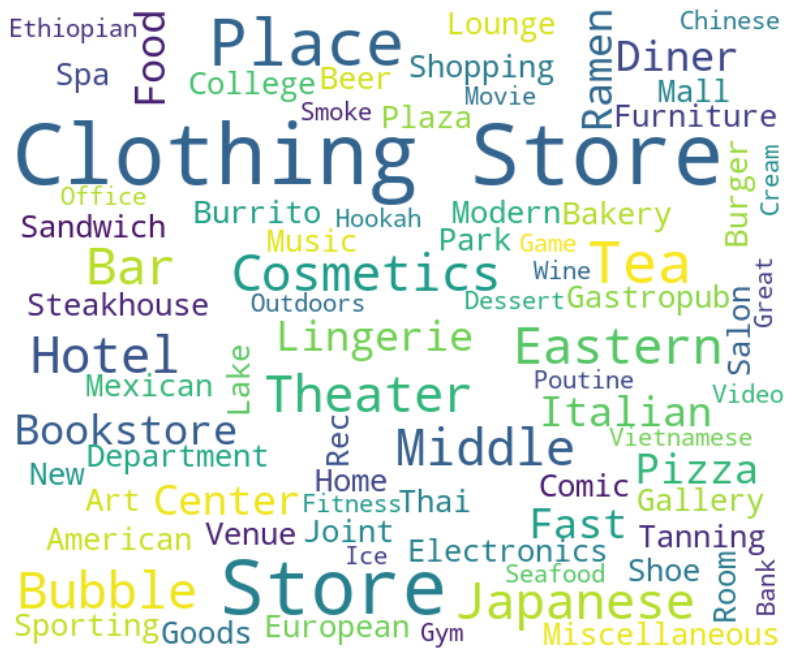

In [74]:
tmpstr=''
tmplist=neighborhoods_venues_sorted[
        neighborhoods_venues_sorted['Cluster Labels']==4
    ]['Neighbourhood'].tolist()
for i,j in zip(toronto_venues['Venue Category'],toronto_venues['Neighbourhood']):
    if j in tmplist:
        tmpstr=tmpstr+' '+i

STOPWORDS.add('Coffee')  
STOPWORDS.add('Restaurant')
STOPWORDS.add('Café')
STOPWORDS.add('Shop')
stopwords = set(STOPWORDS)

wcloud = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=STOPWORDS,
    width=600, height=500
)
# generate the word cloud
wcloud.generate(tmpstr)

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')
plt.show()